# **Simulazione della CityLearn Challenge 2023**

La **CityLearn Challenge 2023** è una competizione internazionale incentrata sull'uso del reinforcement learning per ottimizzare la gestione energetica in ambienti urbani simulati. L'obiettivo principale è quello di controllare in modo intelligente il consumo energetico degli edifici, riducendo picchi di carico sulla rete elettrica e migliorando l'efficienza complessiva attraverso politiche sostenibili. In questa challenge vengono considerati si comfort che consumi.

Nel dataset **citylearn_challenge_2023_phase_3_3** sono inclusi 6 edifici, ognuno dei quali è dotato di sistemi di controllo per il cooling device e per le batterie, e in tutti gli edifici è presente un pannello fotovoltaico. Questo significa che ogni edificio ha la capacità di auto-generare energia solare, contribuendo così a ridurre la dipendenza dalla rete elettrica e a sfruttare l’energia rinnovabile per compensare i picchi di carico e migliorare l’efficienza energetica. Inoltre, non sono inclusi veicoli elettrici, mentre è prevista la possibilità che si verifichino interruzioni di corrente (power outages).

In questa simulazione, utilizziamo l'algoritmo Soft Actor-Critic (SAC), una tecnica off-policy particolarmente adatta a contesti continui e stocastici come quelli modellati in CityLearn.

Durante l’analisi, verranno valutati i risultati in base a diversi reward functions, per comprendere come ciascuno influenzi l'apprendimento e il comportamento dell'agente.



## **Reward Base Reward**


----

**Lista degli import**

In [1]:
from citylearn.agents.sac import SAC as Agent
from citylearn.citylearn import CityLearnEnv
from citylearn.reward_function import * 
from citylearn.wrappers import *

# Importo reward e wrapper corretti di CityLearn
from rewards.CityLearnReward import SolarPenaltyAndComfortReward
from rewards.ComfortandConsumptionReductionReward import ComfortandConsumptionReductionReward

#import per strutture dati
import pandas as pd
from datetime import datetime

#import per grafici
from utils import plotting_functions as plt
from IPython.display import display, Markdown

#permette di nascondere i warning
import warnings
warnings.filterwarnings("ignore")


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
# Inizializza l'ambiente
env = CityLearnEnv('citylearn_challenge_2023_phase_3_3', central_agent=True)
env.random_seed=0
# Imposto un nuovo reward, rispetto a quello impostato di default
rf = RewardFunction(env.schema)
env.reward_function = rf

# Imposto l'agente
model = Agent(env)

# Imposto l'edificio di confronto e quanti episodi vengono effettuati dagli agenti
num_building = 0
num_episodes = 10 

# Reset
observations, _ = env.reset()

# Training sull'ambiente
model.learn(episodes=num_episodes, deterministic_finish=True)




La funzione **learn()** esegue più episodi sull'ambiente addestrando l'agente. Mentre l'ultimo episodio eseguito manualmente, viene eseguito in modalità **deterministic_finish**. In questa fase finale, l'agente utilizza esclusivamente la policy appresa per selezionare le azioni, senza ulteriori aggiornamenti o esplorazioni.


----

## **Confronto con Baseline**

In questa simulazione vengono esclusivamente confrontati gli algoritmi SAC e SACRBC, con il ComfortReward. La valutazione di altri reward viene lasciata alla relazione che raccoglierà solo i valori delle **cost_function**. I seguenti valori sono presi in considerazione come risultato di 4 episodi di training, in quanto risultano sufficienti al raggiungimento della convergenza.


In [3]:
# Vengono filtrare le cost_function desiderate
kpis_names = { 'electricity_consumption_total':'Consumo totale della rete',
               'carbon_emissions_total':'Emissioni',
              'discomfort_proportion':'Proporzione del tempo fuori dal comfort',
              'daily_peak_minus_load_factor_average': 'Misura dell inefficenza nell uso giornaliero della potenza disponibile',
              'daily_peak_average': 'Picco medio giornaliero',
              'all_time_peak_average': 'picco massimo dei consumi nel distretto',
              'one_minus_thermal_resilience_proportion': 'Discomfort proportion in interruzioni elettriche',
              'annual_normalized_unserved_energy_total': 'domanda non soddisfatta a causa di carenza di energia',
              'ramping_average': 'differenza media tra consumo al timestep corrente al precedente ',
              #Qua si aggiungono cost_function
}

display(Markdown(f"### **SAC - Base Version**"))
display(Markdown("----"))

kpis = env.evaluate()
kpis = kpis[(kpis['cost_function'].isin(kpis_names))].dropna()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
display(kpis)



### **SAC - Base Version**

----

name,Building_1,Building_2,Building_3,Building_4,Building_5,Building_6,District
cost_function,,,,,,,
all_time_peak_average,NaN,NaN,NaN,NaN,NaN,NaN,0.794
annual_normalized_unserved_energy_total,0.011,0.027,0.009,0.013,0.016,0.028,0.017
carbon_emissions_total,0.579,0.757,0.708,0.675,0.422,0.467,0.601
daily_peak_average,NaN,NaN,NaN,NaN,NaN,NaN,0.676
discomfort_proportion,0.872,0.446,0.698,0.650,0.989,0.872,0.754
electricity_consumption_total,0.582,0.759,0.709,0.675,0.426,0.467,0.603
one_minus_thermal_resilience_proportion,1.000,1.000,1.000,1.000,1.000,1.000,1.000
ramping_average,NaN,NaN,NaN,NaN,NaN,NaN,0.937



------

## **Comportamento dei consumi**

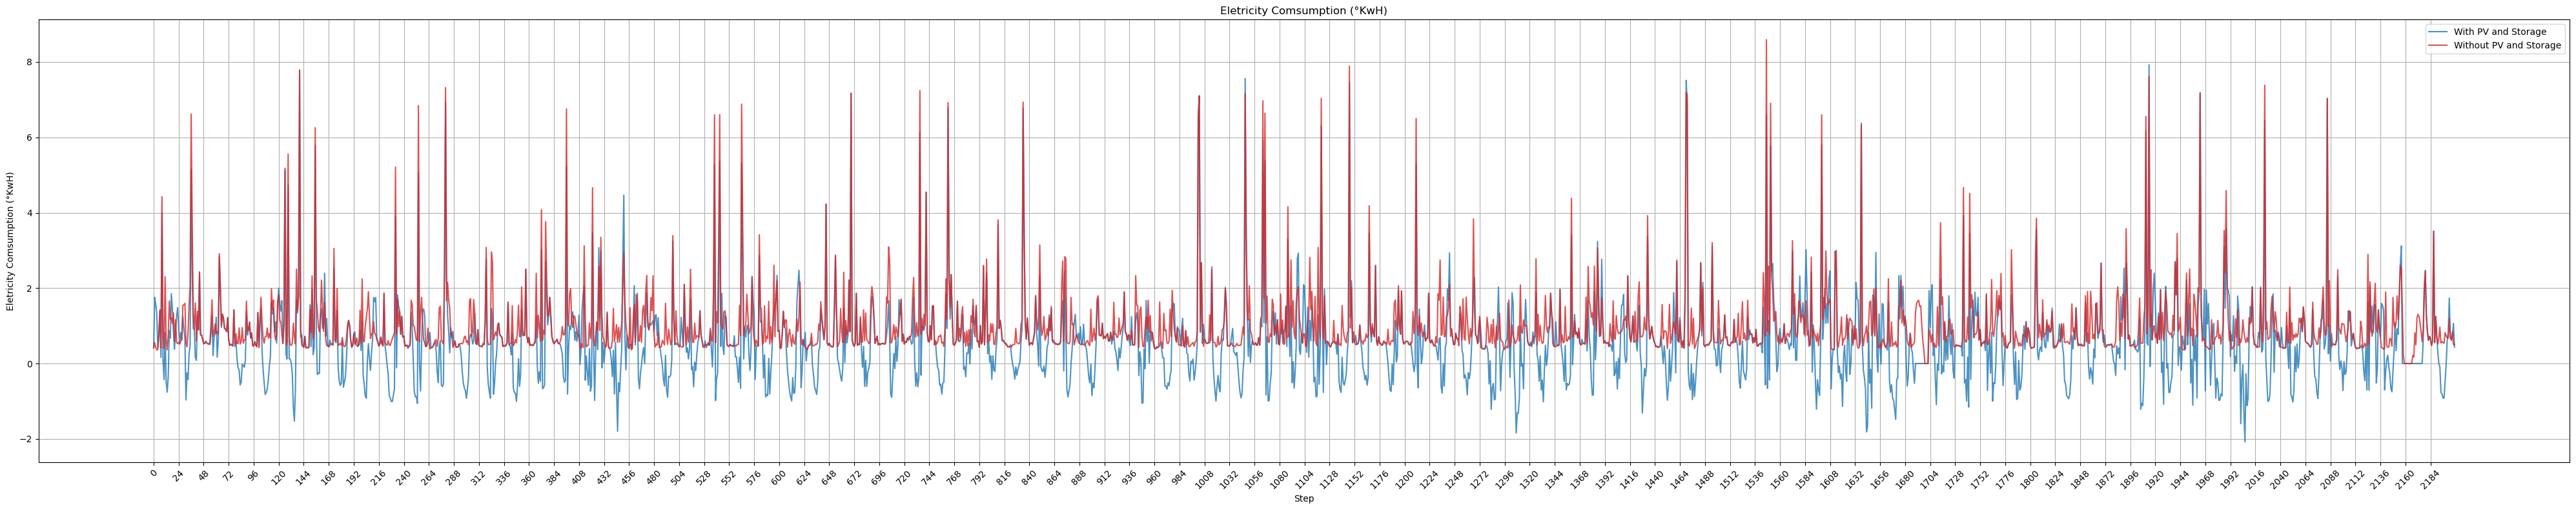

In [4]:
#Calcola il consumo di elettricità totale dell'edificio
energy_with_pv= env.unwrapped.buildings[num_building].net_electricity_consumption
energy_without_pv = env.unwrapped.buildings[num_building].net_electricity_consumption_without_storage_and_pv

plt.plot_comparison_two(
    energy_with_pv,
    energy_without_pv,
    ylabel='Eletricity Comsumption (°KwH)',
    title='Eletricity Comsumption (°KwH)',
    label1='With PV and Storage',
    label2='Without PV and Storage'
)

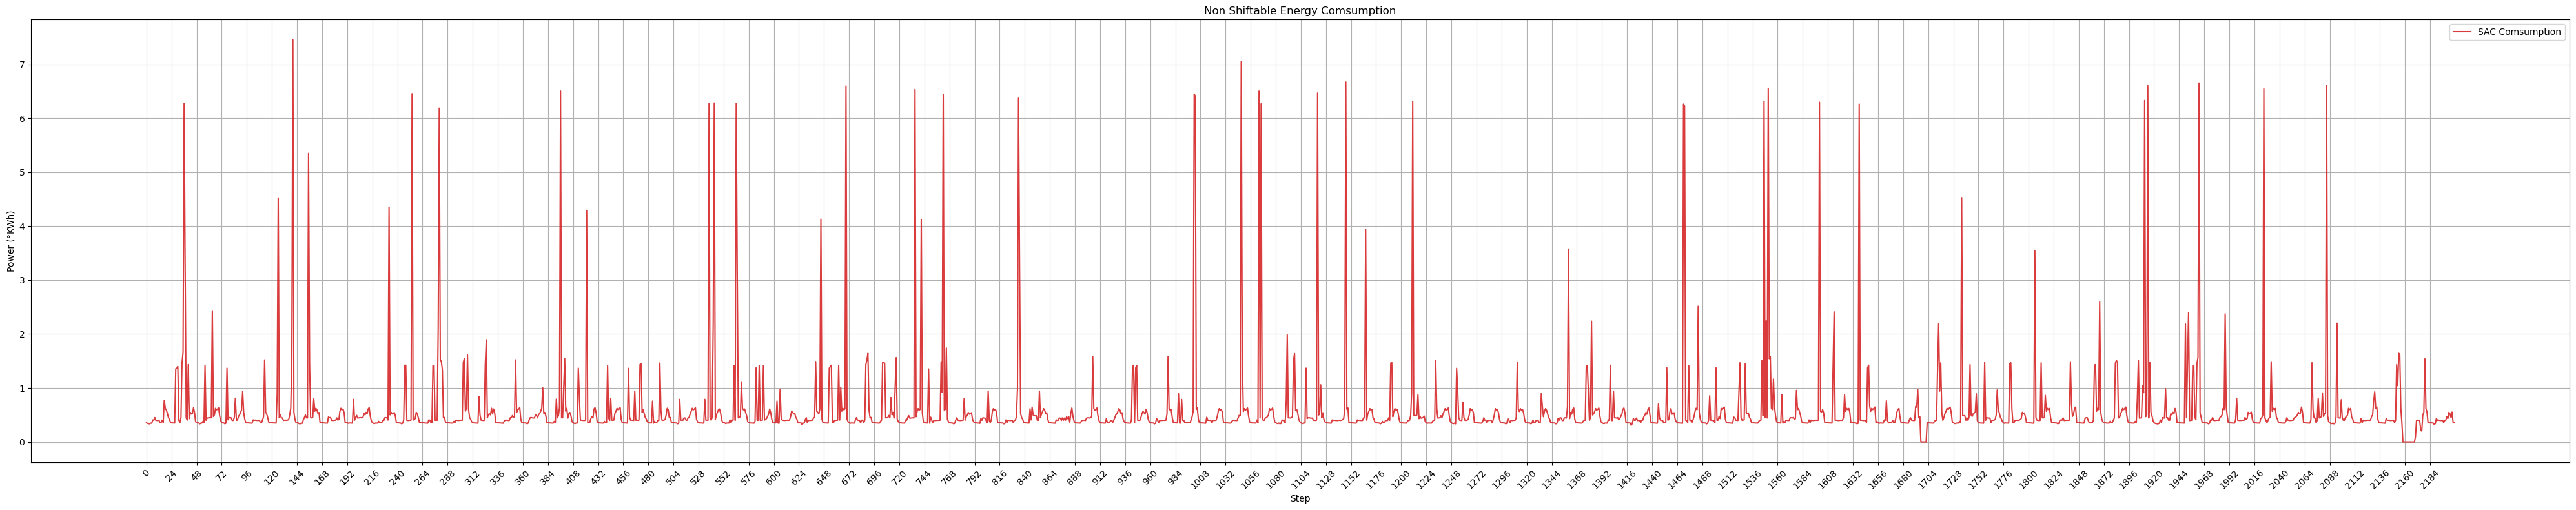

In [5]:

non_energy_sac = env.unwrapped.buildings[num_building].non_shiftable_load_electricity_consumption

plt.plot_single_agent(
    non_energy_sac,
    ylabel='Power (°KWh)',
    title='Non Shiftable Energy Comsumption',
    label='SAC Comsumption',

)


------

## **Comportamento delle temperature**

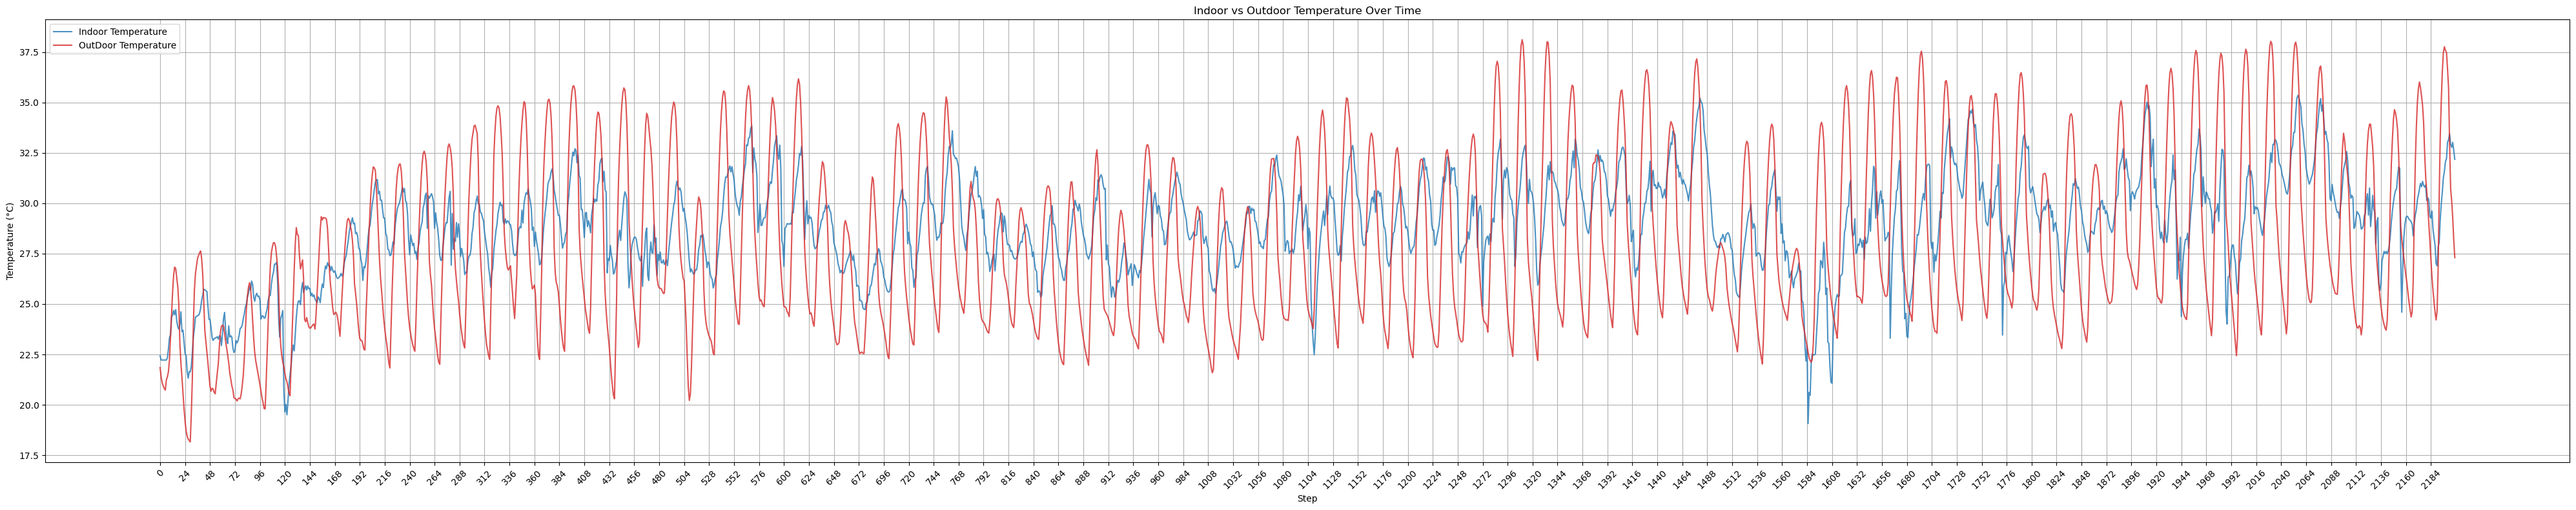

In [6]:
indoor_base_temp = env.unwrapped.buildings[num_building].indoor_dry_bulb_temperature
outdoor_temp = env.unwrapped.buildings[num_building].weather.outdoor_dry_bulb_temperature


plt.plot_comparison_two(
    indoor_base_temp,
    outdoor_temp,
    ylabel='Temperature (°C)',
    title='Indoor vs Outdoor Temperature Over Time',
    label1='Indoor Temperature',
    label2='OutDoor Temperature'
)


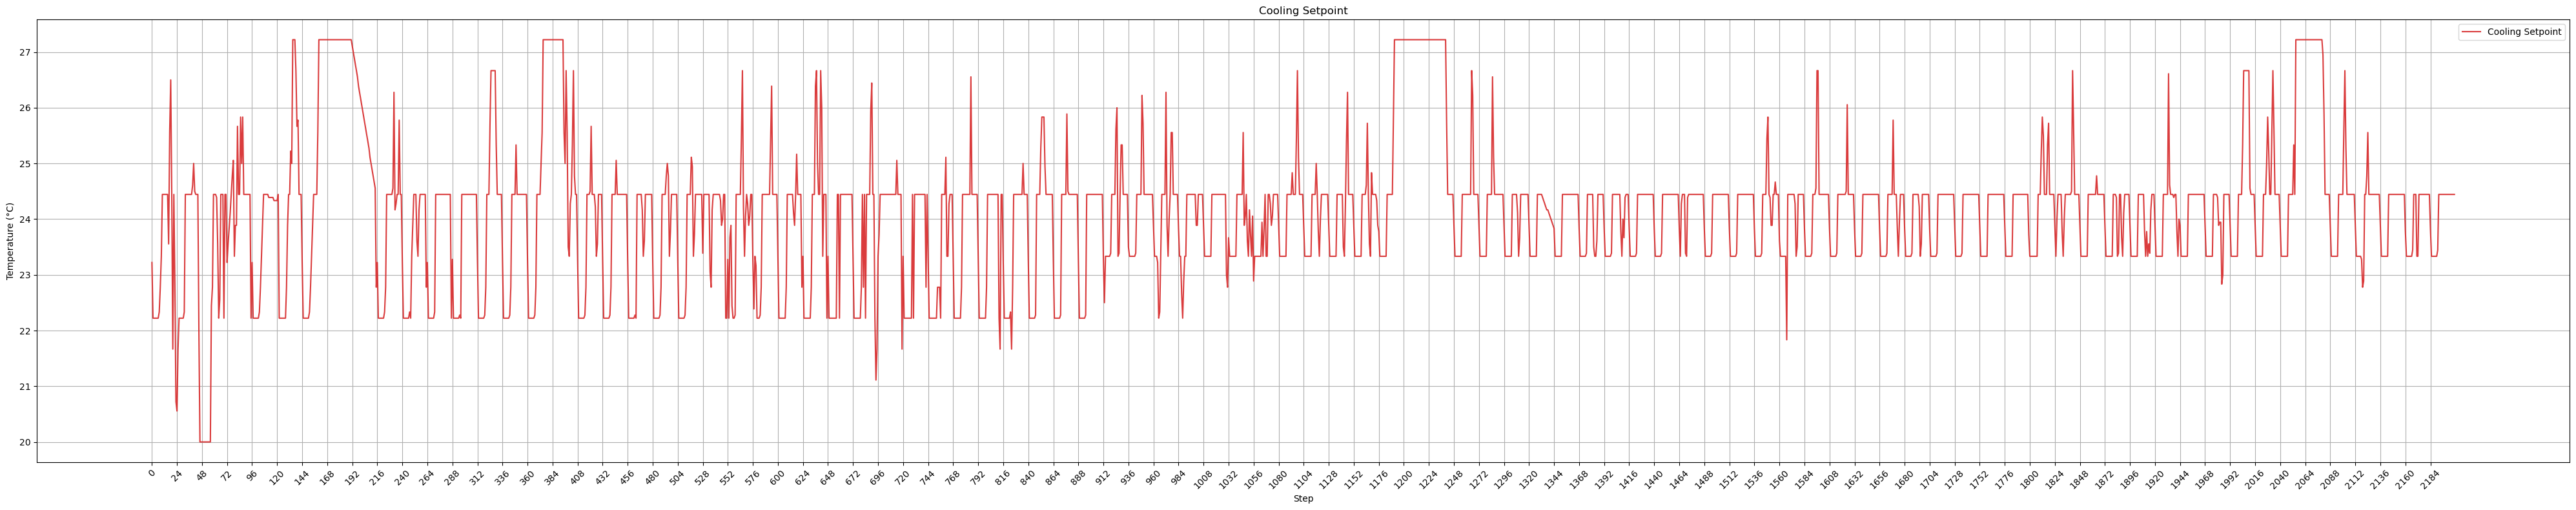

In [7]:
plt.plot_single_agent(
    agent_data=env.buildings[num_building].indoor_dry_bulb_temperature_cooling_set_point,
    ylabel='Temperature (°C)',
    title='Cooling Setpoint',
    label='Cooling Setpoint'
)


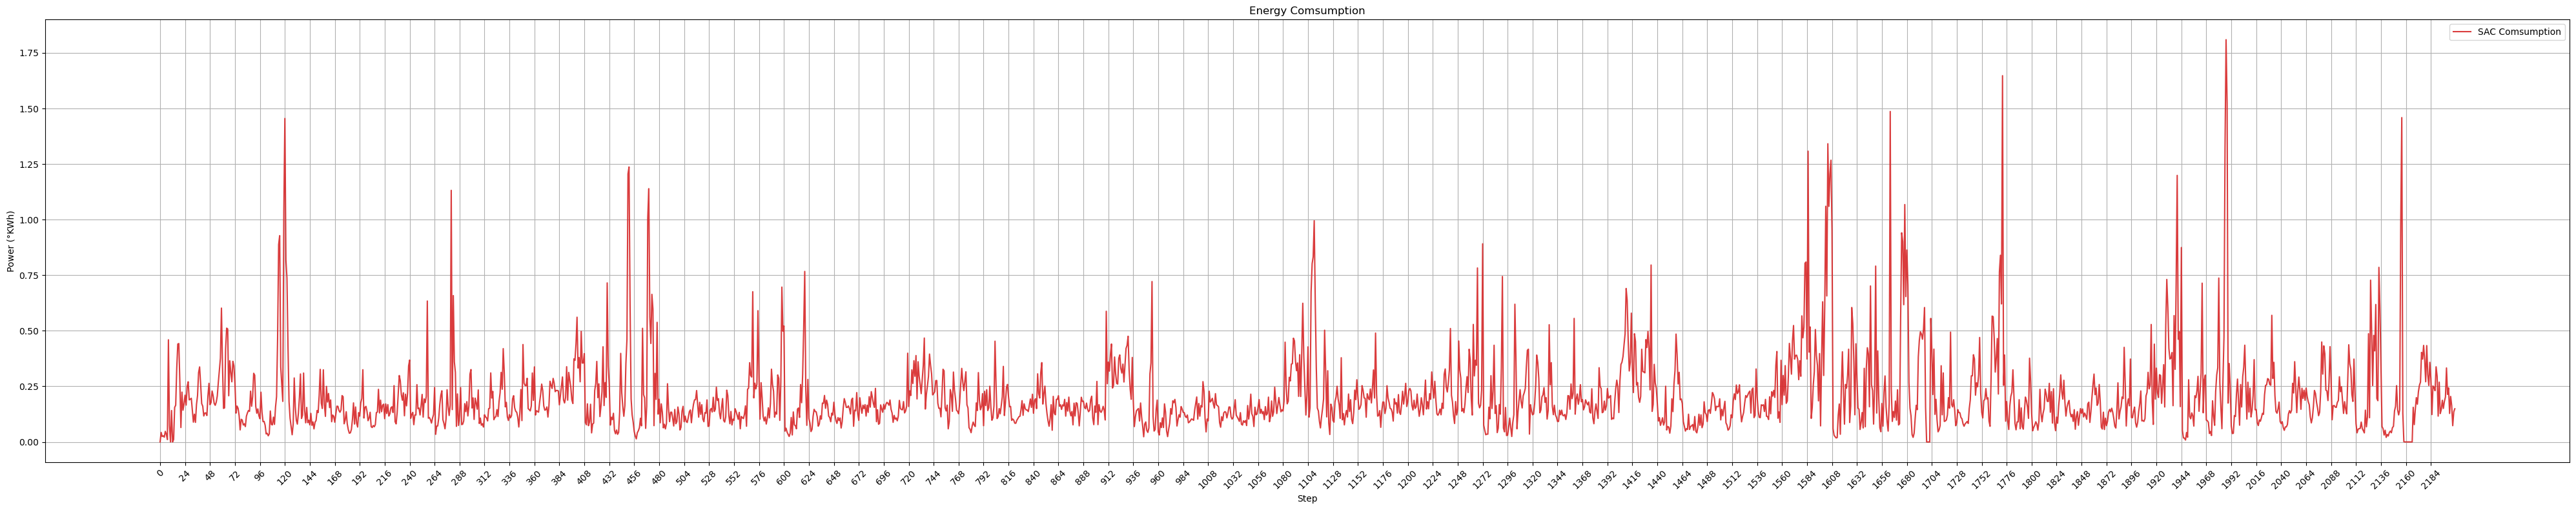

In [8]:
#Questa componente estrae la potenza utilizzata dei dispositivi che servono per regolare la temperatura ambientale

cooler_energy_sac = env.unwrapped.buildings[num_building].cooling_electricity_consumption

plt.plot_single_agent(
    cooler_energy_sac,
    ylabel='Power (°KWh)',
    title='Energy Comsumption',
    label='SAC Comsumption',

)


----

## **Comportamento nell'utilizzo delle batterie**

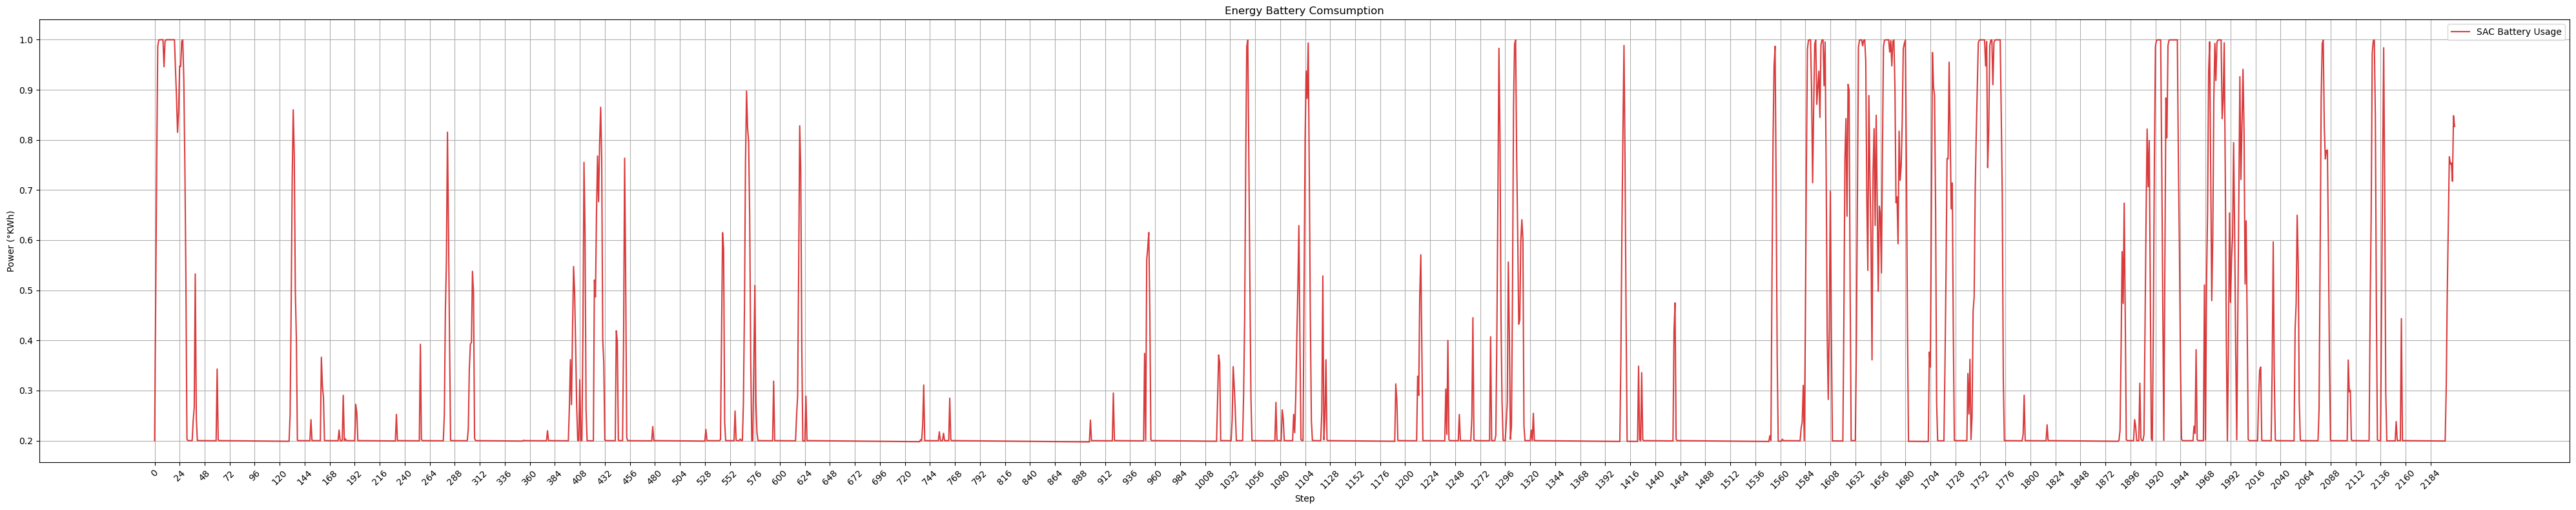

In [9]:
agent_data1 = env.unwrapped.buildings[num_building].electrical_storage.soc

plt.plot_single_agent(
    agent_data1,
    ylabel='Power (°KWh)',
    title='Energy Battery Comsumption',
    label='SAC Battery Usage'
)


----

## **Comportamento delle emissioni**

L'emissioni sono strettamente legate ai consumi di energia della rete, perciò le caratteristiche precedenti si propagano anche qua.

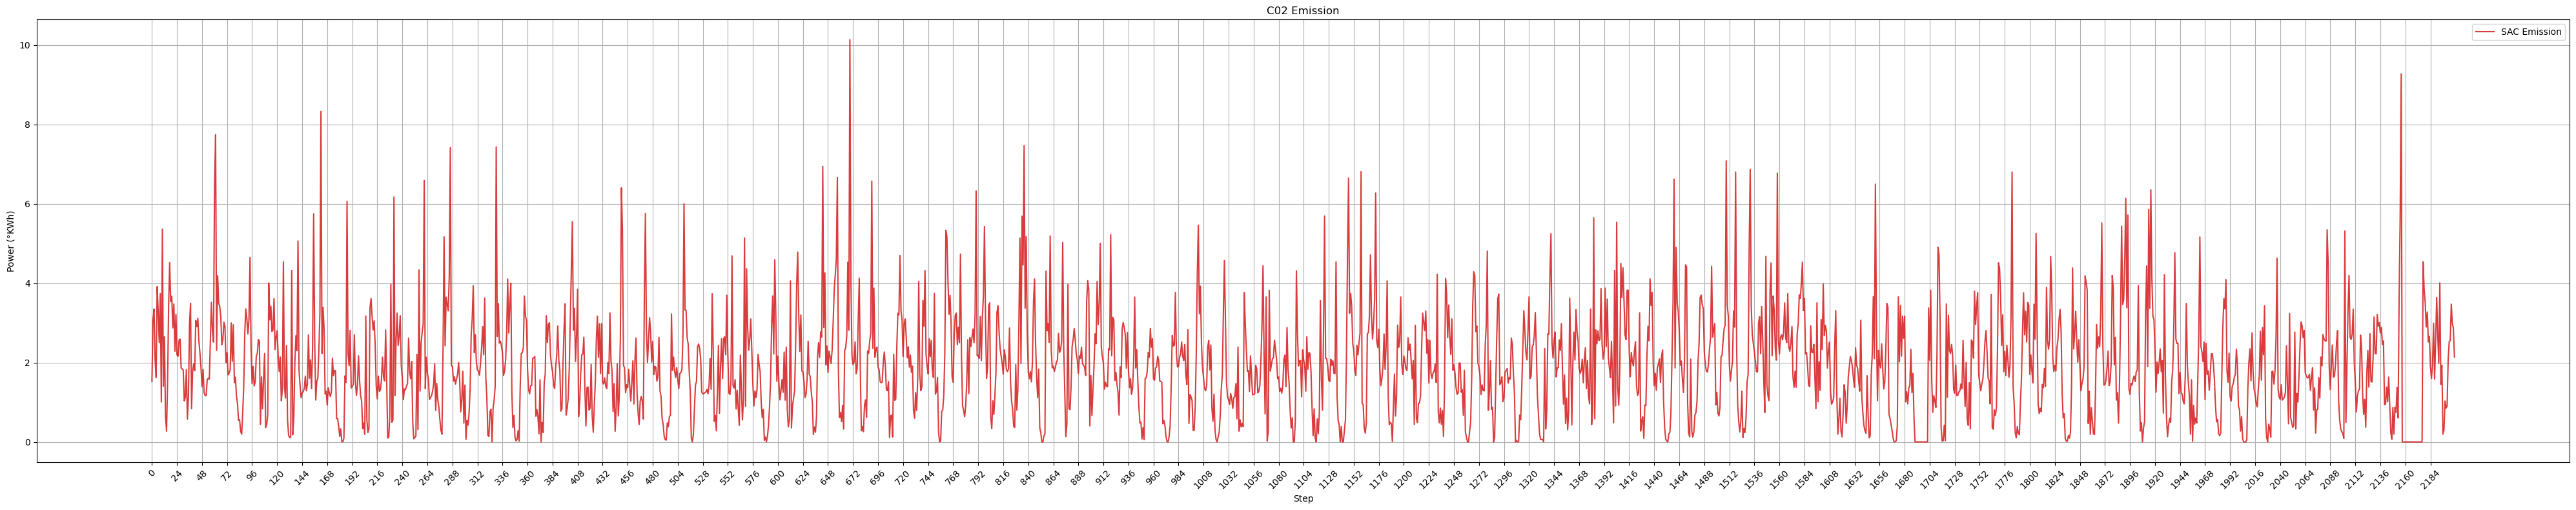

In [10]:
agent_data1 = env.unwrapped.net_electricity_consumption_emission


plt.plot_single_agent(
    agent_data1,
    ylabel='Power (°KWh)',
    title='C02 Emission',
    label='SAC Emission'
)


----

## **Comportamento dei reward e dell'apprendimento**



### **SAC - Base Version**

----

,Episodio,Reward Min,Reward Max,Reward Somma,Reward Media
0,1,-24.873072,0.0,-19030.730469,-8.622895
1,2,-24.416864,0.0,-10889.715820,-4.934171
2,3,-23.949959,0.0,-11850.206055,-5.369373
3,4,-23.697603,0.0,-11776.552734,-5.336000
4,5,-26.152552,0.0,-12019.670898,-5.446158
5,6,-22.542404,0.0,-11629.312500,-5.269285
6,7,-29.403015,0.0,-13116.479492,-5.943126
7,8,-22.712481,0.0,-11434.980469,-5.181232
8,9,-25.665579,0.0,-11541.091797,-5.229312
9,10,-21.327627,0.0,-9759.144531,-4.421905


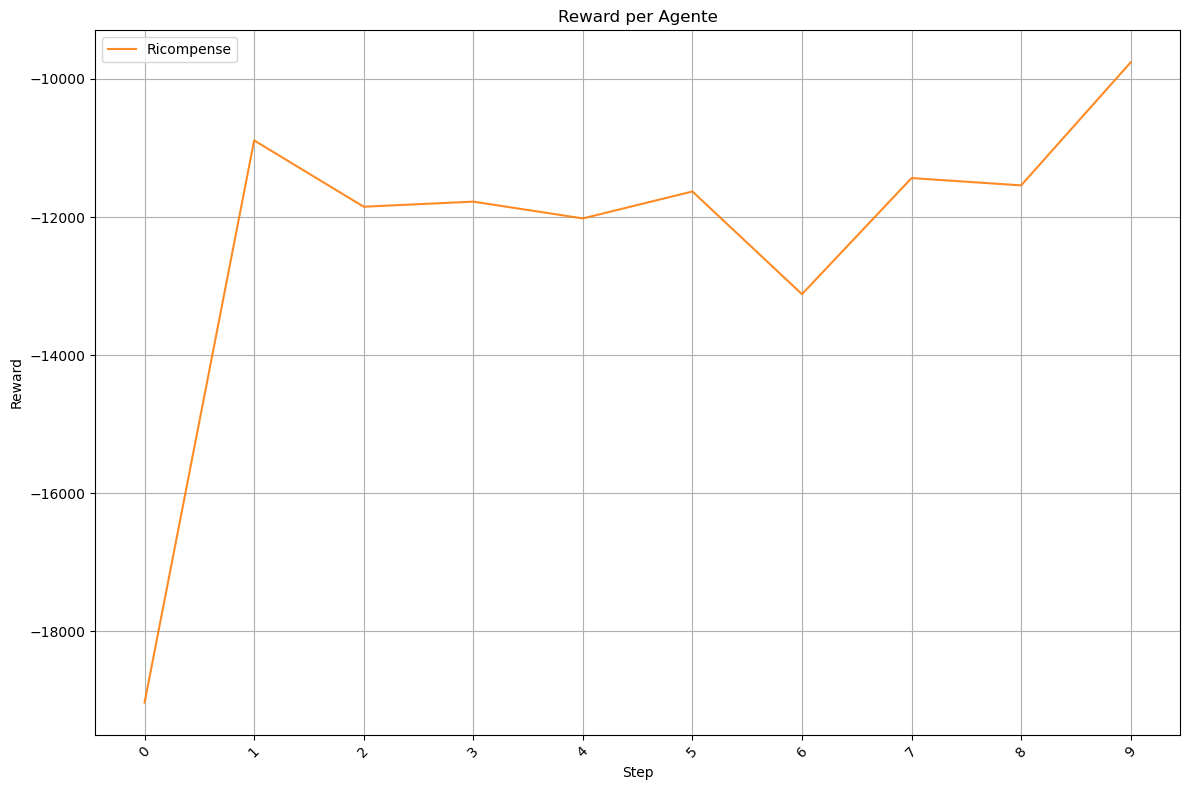

In [11]:
df = plt.create_episode_table(env.unwrapped.episode_rewards)

display(Markdown(f"### **SAC - Base Version**"))
display(Markdown("----"))
display(df)

plt.plot_rewards(df['Reward Somma'])
